# **`flygym`-MuJoCo exercise: CPG controller** 

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_CPG_control.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).


In [1]:
import PIL.Image

import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

import cv2


from flygym.util.CPG_helpers import (advancement_transfer, phase_oscillator, sine_output, initialize_solver,
                         phase_biases_tripod_measured, phase_biases_tripod_idealized,
                         phase_biases_ltetrapod_idealized, phase_biases_metachronal_idealized,
                         plot_phase_amp_output)

from flygym.arena.mujoco_arena import MixedTerrain

from scipy.spatial.transform import Rotation as R

In [2]:
arena = MixedTerrain()

In [3]:
# Initialize the simulation
adhesion = True
run_time = 1
sim_params = MuJoCoParameters(timestep=1e-4, render_mode="saved", render_playspeed=0.05, render_camera="Animat/camera_front",
                              enable_adhesion=adhesion, draw_adhesion=True, draw_contacts = True, decompose_contacts=False, draw_gravity = True, align_camera_with_gravity = True, contact_threshold=0.1)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    #arena = MixedTerrain(),
    spawn_pos = [3.0, 0, 0.5]
)

num_steps_base = int(run_time / nmf.timestep)

In [4]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [6]:
legs = ["RF", "RM", "RH", "LF", "LM", "LH"]
n_oscillators = len(legs)

t = np.arange(0, run_time, nmf.timestep)

n_joints = len(nmf.actuated_joints)
leg_ids = np.arange(len(legs)).astype(int)
joint_ids = np.arange(n_joints).astype(int)
# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

In [7]:
# lets say we want 10 oscillations in the time period
n_steps = 12
frequencies = np.ones(n_oscillators) * n_steps / run_time

# For now each oscillator have the same amplitude
target_amplitudes = np.ones(n_oscillators) * 1.0
rates = np.ones(n_oscillators) * 20.0

gait = "tripod"

if gait == "tripod":
    phase_biases = phase_biases_tripod_idealized * 2 * np.pi
elif gait == "metachronal":
    phase_biases = phase_biases_metachronal_idealized * 2 * np.pi
elif gait == "tetrapod":
    phase_biases = phase_biases_ltetrapod_idealized * 2 * np.pi

coupling_weights = (np.abs(phase_biases) > 0).astype(float) * 10.0 

# Simulation

In [8]:
# Set variables
nmf.reset()

n_stabilisation_steps = 2000
num_steps = n_stabilisation_steps + num_steps_base
inv_gravity = False
slope = 20
inv_gravity_indicator_radius = 25

if inv_gravity:
    inv_grav_time = []
    reset_grav_time = []
    inverted_grav = False
else:
    inv_grav_time = [num_steps-5000]
    reset_grav_time = [num_steps-1000]
    inverted_grav = False



# Initilize the simulation
np.random.seed(42)
start_ampl = np.ones(6)*0.2
obs, info = nmf.reset()
solver = initialize_solver(phase_oscillator, "dopri5", nmf.curr_time,
                            n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                start_ampl, rates,
                                int_params={"atol": 1e-6, "rtol": 1e-6, "max_step":100000})


# Initalize storage
obs_list = []
phases = np.zeros((num_steps, n_oscillators))
amplitudes = np.zeros((num_steps, n_oscillators))

all_adhesions = []

joint_angles = np.zeros((num_steps, n_joints))
input_joint_angles = np.zeros(len(nmf.actuated_joints))


for i in trange(num_steps):

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases[i, :] = phase
    amplitudes[i, :] = amp    

    if i == n_stabilisation_steps:
        # Now set the amplitude to their real values
        solver.set_f_params(n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                target_amplitudes, rates)
    if i > inv_grav_time[0]-500 and False:
        input_joint_angles = data_block[joint_ids, 0]
    elif i > n_stabilisation_steps:
        indices = advancement_transfer(phase, interp_step_duration, match_leg_to_joints)
        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = data_block[joint_ids, 0] + \
                  (data_block[joint_ids, indices]-data_block[joint_ids, 0])*amp[match_leg_to_joints]
    else:
        input_joint_angles = data_block[joint_ids, 0]

    joint_angles[i, :] = input_joint_angles
    if i < n_stabilisation_steps:
        adhesion_signal = np.zeros(6)
    else:
        adhesion_signal = nmf.get_adhesion_vector()

    action = {"joints": input_joint_angles, "adhesion": adhesion_signal}
    all_adhesions.append(adhesion_signal)
    
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list.append(obs)
    render_status = nmf.render()

    if i in inv_grav_time:
        nmf.set_slope(slope, "y")
        #z_rot_180 = R.from_euler('z', -180, degrees=True)
        #nmf.camera_rot = z_rot_180.as_matrix()@nmf.camera_rot
        #nmf.set_gravity([-9810, 0, 0])

        inverted_grav = True
    elif i in reset_grav_time:
        #nmf.set_slope(0, "x")
        nmf.set_gravity([-7000, 0, -100])
        #nmf.set_gravity([-9810, 0, 0])
        #inverted_grav = False
        pass
    
    if render_status and inverted_grav:
        last_frame = nmf.get_last_frame()
        cv2.circle(last_frame,(inv_gravity_indicator_radius,inv_gravity_indicator_radius), inv_gravity_indicator_radius, (0, 0, 255), -1)


 91%|█████████▏| 10972/12000 [00:35<00:03, 293.35it/s]/Users/stimpfli/Desktop/flygym/flygym/envs/nmf_mujoco.py:1059: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot_simple = R.align_vectors(
 92%|█████████▏| 11035/12000 [00:35<00:03, 288.89it/s]

[[-0.99989797  0.         -0.01428426]] [ 0.         -1.55651158  3.14159265] [[ 1.90172817e-16  0.00000000e+00 -1.00000000e+00]] [[ 0.  0. -1.]]
[ 0.         -1.55651158  3.14159265] [0. 0. 0.] [[-0.99989797  0.         -0.01428426]] [[-0.99989797  0.         -0.01428426]]
Removing component 0
[ 0.         -1.55651158  3.14159265] [ 0.         -1.55651158  0.        ] [[ 1.56289194e-14  0.00000000e+00 -1.00000000e+00]] [[-0.99989797  0.         -0.01428426]]
[ 0.         -1.55651158  3.14159265] [ 0.         -1.55651158  3.14159265] [[-1.56289194e-14  1.91323381e-30 -1.00000000e+00]] [[ 1.56289194e-14  0.00000000e+00 -1.00000000e+00]]
Removing component 2
[ 0.         -1.55651158  0.        ]


100%|██████████| 12000/12000 [00:37<00:00, 316.73it/s]


In [9]:
video_path = Path(f"CPG_adhesion/test.mp4")
nmf.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

In [40]:
dir(nmf.physics.data), nmf.physics.data.actuator(194).force

(['B_colind',
  'B_rowadr',
  'B_rownnz',
  'D_colind',
  'D_rowadr',
  'D_rownnz',
  '_HAS_DYNAMIC_ATTRIBUTES',
  '__class__',
  '__copy__',
  '__delattr__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__getstate__',
  '__gt__',
  '__hash__',
  '__init__',
  '__init_subclass__',
  '__le__',
  '__lt__',
  '__module__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__setattr__',
  '__setstate__',
  '__sizeof__',
  '__str__',
  '__subclasshook__',
  '__weakref__',
  '_data',
  '_make_copy',
  '_model',
  'act',
  'act_dot',
  'actuator',
  'actuator_force',
  'actuator_length',
  'actuator_moment',
  'actuator_velocity',
  'body',
  'bvh_active',
  'cacc',
  'cam',
  'cam_xmat',
  'cam_xpos',
  'camera',
  'cdof',
  'cdof_dot',
  'cfrc_ext',
  'cfrc_int',
  'cinert',
  'contact',
  'contact_force',
  'copy',
  'crb',
  'ctrl',
  'cvel',
  'efc_AR',
  'efc_AR_colind',
  'efc_AR_rowadr',
  'efc_AR_r

In [45]:
for i in range(6):
    print(nmf.physics.data.actuator(194-i).name)
    print(nmf.physics.data.actuator(194-i).force)
    print(nmf.physics.data.actuator(194-i).length)
    print(nmf.physics.data.actuator(194-i).velocity)
    

Animat/RHTarsus5_adhesion
[0.]
[0.]
[0.]
Animat/RMTarsus5_adhesion
[20.]
[0.]
[-0.46202654]
Animat/RFTarsus5_adhesion
[0.]
[0.]
[0.]
Animat/LHTarsus5_adhesion
[20.]
[0.]
[-2.10782337]
Animat/LMTarsus5_adhesion
[0.]
[0.]
[0.]
Animat/LFTarsus5_adhesion
[20.]
[0.]
[2.10137793]


In [59]:
for attr in ['actuator_force', 'actuator_length', 'actuator_moment', 'actuator_velocity']:
    print(attr, getattr(nmf.physics.data, attr).shape)

actuator_force [ 3.99157796e-03  0.00000000e+00  0.00000000e+00 -3.09602780e-01
  0.00000000e+00  0.00000000e+00  2.40455939e-04  0.00000000e+00
  0.00000000e+00  3.04292651e-04  0.00000000e+00  0.00000000e+00
 -4.17725914e-03  0.00000000e+00  0.00000000e+00 -1.70234468e-03
  0.00000000e+00  0.00000000e+00 -1.87733552e-03  0.00000000e+00
  0.00000000e+00 -1.01176776e-03  0.00000000e+00  0.00000000e+00
 -6.47286166e-04  0.00000000e+00  0.00000000e+00 -1.05390510e-04
  0.00000000e+00  0.00000000e+00 -1.42397505e-04  0.00000000e+00
  0.00000000e+00  7.86213638e-05  0.00000000e+00  0.00000000e+00
 -7.90537399e-04  0.00000000e+00  0.00000000e+00 -4.52495718e-03
  0.00000000e+00  0.00000000e+00 -1.64627082e-04  0.00000000e+00
  0.00000000e+00 -1.80108567e-03  0.00000000e+00  0.00000000e+00
  1.08055463e-03  0.00000000e+00  0.00000000e+00 -1.42564780e-03
  0.00000000e+00  0.00000000e+00  3.84205834e-05  0.00000000e+00
  0.00000000e+00  4.46325207e-04  0.00000000e+00  0.00000000e+00
 -2.170113

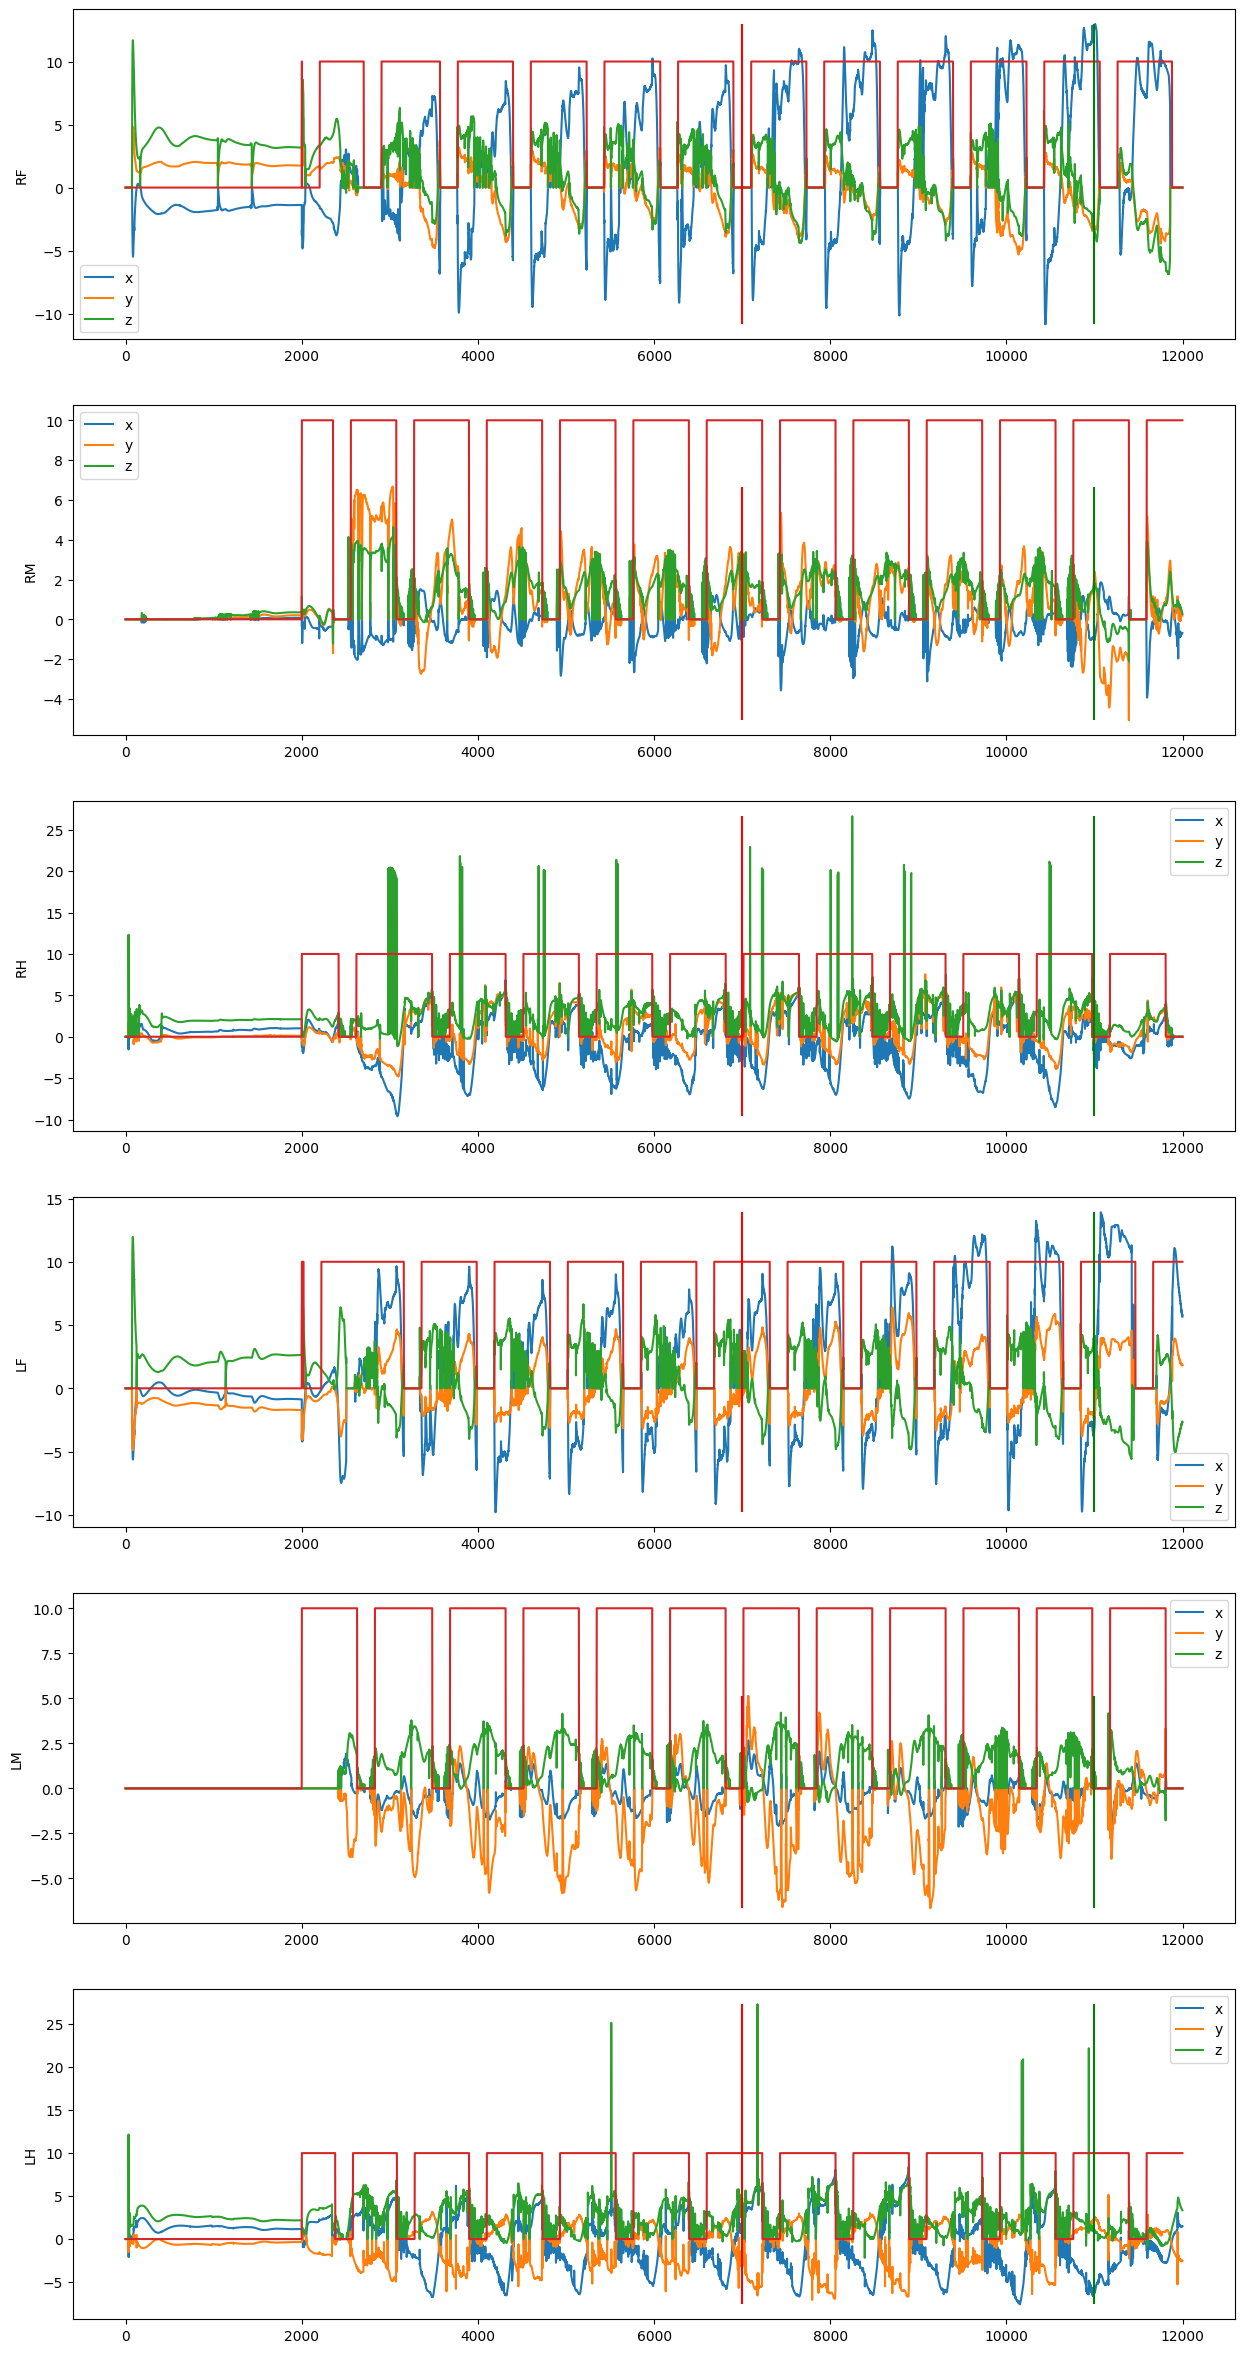

In [10]:
# plot contact forces
all_adhesions = np.array(all_adhesions)
legs = ["RF", "RM", "RH", "LF", "LM", "LH"]
n_legs = len(legs)
legs_contact_sensors = [[i for i, seg in enumerate(nmf.contact_sensor_placements) if leg in seg] for leg in legs]
adhesion_leg_idx = [i for leg in legs for i, adhesion_actuator in enumerate(nmf.adhesion_actuators) if leg in adhesion_actuator.name]

contact_forces = np.array([obs["contact_forces"] for obs in obs_list])
leg_contact_forces = np.sum(contact_forces[:, :, legs_contact_sensors], axis=-1)

fig, axs = plt.subplots(n_legs, 1, figsize=(15, 30))
for i in range(n_legs):
    lcf = leg_contact_forces[:, :, i]
    for k in range(3):
        axs[i].plot(lcf[:, k])
    axs[i].legend(["x", "y", "z"])
    axs[i].plot(all_adhesions[:, adhesion_leg_idx[i]]*10)
    max_lcf = np.max(lcf)
    min_lcf = np.min(lcf)

    axs[i].vlines(inv_grav_time, min_lcf, max_lcf, color="red")
    axs[i].vlines(reset_grav_time, min_lcf, max_lcf, color="green")
    axs[i].set_ylabel(legs[i])

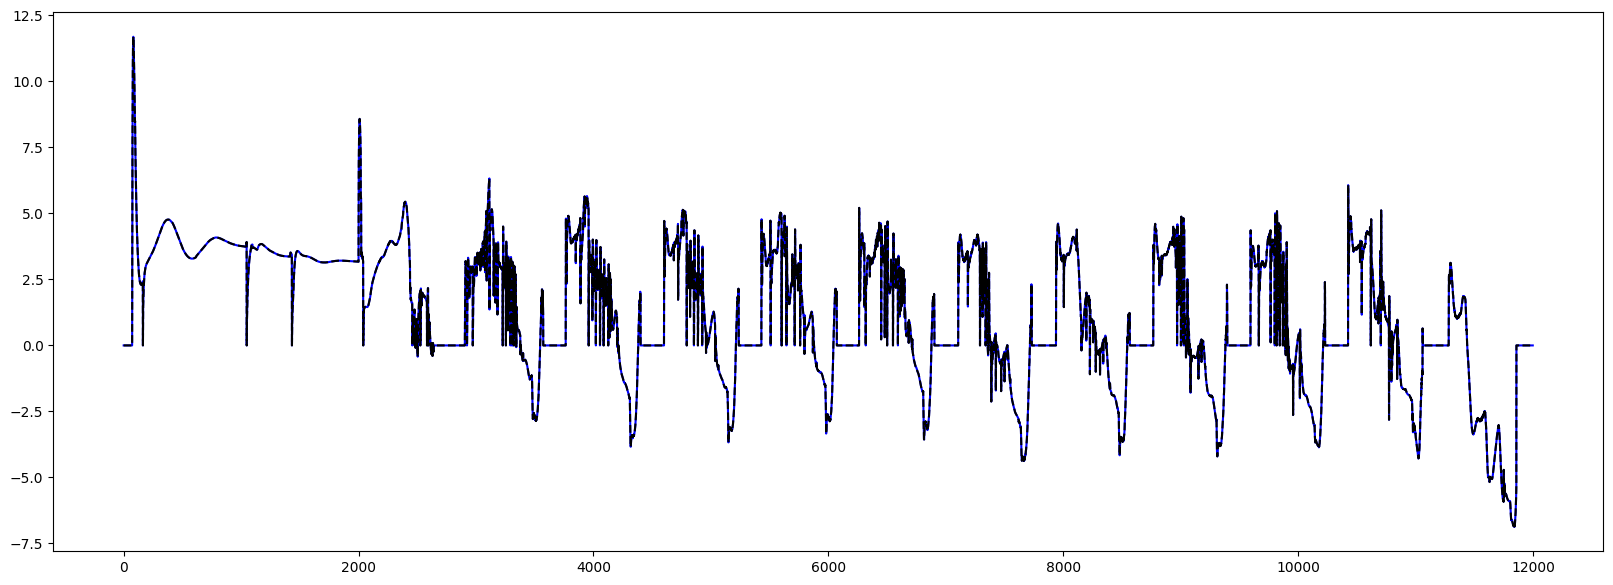

In [11]:
c = leg_contact_forces[:, 2, 0].copy()

new_contact = []
subtract = 0

old_value = 0
start_subtract = []
start_no_subtract = [0]

for i in range(len(c)):
    if np.abs(c[i]-old_value) > 19:
        if subtract == 0:
            subtract = 1
            start_subtract.append(i)
        else:
            subtract = 0
            start_no_subtract.append(i)
        new_contact.append(c[i] - subtract*nmf.sim_params.adhesion_gain)
        old_value = c[i]
    else:
        new_contact.append(c[i] - subtract*nmf.sim_params.adhesion_gain)

fig, ax = plt.subplots(1, 1, figsize=(20, 7))

ax.plot(new_contact, "b")
ax.plot(c, "k--")
for i in range(len(start_no_subtract)-1):
    ax.axvspan(start_no_subtract[i], start_subtract[i], alpha=0.5, color='green')
    ax.axvspan(start_subtract[i], start_no_subtract[i+1], alpha=0.5, color='red')



